# Advanced Customer Segmentation Analysis
## AI Customer Upsell Prediction System

This notebook implements:
- K-Means Clustering (GPU-accelerated)
- DBSCAN for anomaly detection
- Gaussian Mixture Models
- Customer behavior clustering
- Segment profiling and business insights
- Targeted upsell strategies by segment

In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Clustering libraries
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Try to import GPU-accelerated clustering
try:
    import cuml
    from cuml.cluster import KMeans as KMeans_GPU
    from cuml.cluster import DBSCAN as DBSCAN_GPU
    GPU_AVAILABLE = True
    print("✅ GPU-accelerated clustering available (cuML)")
except ImportError:
    GPU_AVAILABLE = False
    print("⚠️ GPU clustering not available, using CPU-based clustering")

import joblib
import json
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 8)

/mnt/c/Users/mohan/Downloads/CTS Hackathon'25/Potential Customers for Upsell/repo/ai-customer-upsell-prediction/ai-customer-upsell-prediction/gpu_venv/lib/python3.10/site-packages/cupy/_environment.py:596: UserWarning: 
--------------------------------------------------------------------------------

  CuPy may not function correctly because multiple CuPy packages are installed
  in your environment:

    cupy-cuda11x, cupy-cuda12x

  Follow these steps to resolve this issue:

    1. For all packages listed above, run the following command to remove all
       existing CuPy installations:

         $ pip uninstall <package_name>

      If you previously installed CuPy via conda, also run the following:

         $ conda uninstall cupy

    2. Install the appropriate CuPy package.
       Refer to the Installation Guide for detailed instructions.

         https://docs.cupy.dev/en/stable/install.html

--------------------------------------------------------------------------------

  war

RuntimeError: Failed to dlopen libcudart.so.12

In [3]:
# Load Data and Prepare for Clustering
print("📊 Loading Data for Customer Segmentation...")

# Load processed data
df = pd.read_csv('../data/processed/telecom_processed.csv')
feature_columns = joblib.load('../models/feature_columns.pkl')

print(f"Dataset Shape: {df.shape}")
print(f"Total Customers: {len(df):,}")
print(f"Features Available: {len(feature_columns)}")

# Select features for clustering (focus on customer behavior)
clustering_features = [
    # Usage patterns
    'Total_Minutes', 'Total_Calls', 'Total_Charges',
    'Day_Usage_Ratio', 'Eve_Usage_Ratio', 'Night_Usage_Ratio', 'Intl_Usage_Ratio',
    
    # Customer lifecycle
    'Account Length', 'Usage_Per_Day', 'Revenue_Per_Day',
    
    # Service interaction
    'CustServ Calls', 'VMail Message',
    
    # Behavioral indicators
    'Customer_Value_Score', 'Engagement_Score', 'Churn_Risk_Score',
    
    # Usage intensity
    'Avg_Call_Duration', 'Revenue_Per_Minute'
]

# Prepare clustering data
X_cluster = df[clustering_features].fillna(0)
X_cluster = X_cluster.replace([np.inf, -np.inf], 0)

print(f"\n🎯 Selected {len(clustering_features)} features for clustering:")
for i, feature in enumerate(clustering_features, 1):
    print(f"  {i:2d}. {feature}")

print(f"\nClustering data shape: {X_cluster.shape}")

📊 Loading Data for Customer Segmentation...
Dataset Shape: (60445, 47)
Total Customers: 60,445
Features Available: 44

🎯 Selected 17 features for clustering:
   1. Total_Minutes
   2. Total_Calls
   3. Total_Charges
   4. Day_Usage_Ratio
   5. Eve_Usage_Ratio
   6. Night_Usage_Ratio
   7. Intl_Usage_Ratio
   8. Account Length
   9. Usage_Per_Day
  10. Revenue_Per_Day
  11. CustServ Calls
  12. VMail Message
  13. Customer_Value_Score
  14. Engagement_Score
  15. Churn_Risk_Score
  16. Avg_Call_Duration
  17. Revenue_Per_Minute

Clustering data shape: (60445, 17)


In [4]:
# Data Preprocessing for Clustering
print("🔧 Preprocessing Data for Clustering...")

# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

# Alternative scaling approaches
minmax_scaler = MinMaxScaler()
X_minmax = minmax_scaler.fit_transform(X_cluster)

print(f"✅ Features scaled using StandardScaler")
print(f"✅ Features scaled using MinMaxScaler")

# Apply PCA for dimensionality reduction and visualization
pca = PCA(n_components=0.95)  # Keep 95% of variance
X_pca = pca.fit_transform(X_scaled)

print(f"✅ PCA applied: {X_cluster.shape[1]} → {X_pca.shape[1]} components")
print(f"   Explained variance: {pca.explained_variance_ratio_.sum():.3f}")

# Create 2D PCA for visualization
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X_scaled)

print(f"✅ 2D PCA for visualization: explained variance = {pca_2d.explained_variance_ratio_.sum():.3f}")

# Display feature statistics
print(f"\n📊 Clustering Data Statistics:")
print(f"  Original features: {X_cluster.shape[1]}")
print(f"  PCA components (95% variance): {X_pca.shape[1]}")
print(f"  Samples: {X_cluster.shape[0]:,}")

🔧 Preprocessing Data for Clustering...
✅ Features scaled using StandardScaler
✅ Features scaled using MinMaxScaler
✅ PCA applied: 17 → 12 components
   Explained variance: 0.962
✅ 2D PCA for visualization: explained variance = 0.322

📊 Clustering Data Statistics:
  Original features: 17
  PCA components (95% variance): 12
  Samples: 60,445


📈 Finding Optimal Number of Clusters
🔄 Testing different numbers of clusters...
  Testing k=2... Silhouette: 0.703
  Testing k=3... Silhouette: 0.274
  Testing k=4... Silhouette: 0.288
  Testing k=5... Silhouette: 0.290
  Testing k=6... Silhouette: 0.320
  Testing k=7... Silhouette: 0.316
  Testing k=8... Silhouette: 0.322
  Testing k=9... Silhouette: 0.328
  Testing k=10... Silhouette: 0.331

🎯 Optimal Number of Clusters:
  Silhouette Score: k = 2 (score: 0.703)
  Calinski-Harabasz: k = 2 (score: 9612.5)
  Davies-Bouldin: k = 10 (score: 1.183)


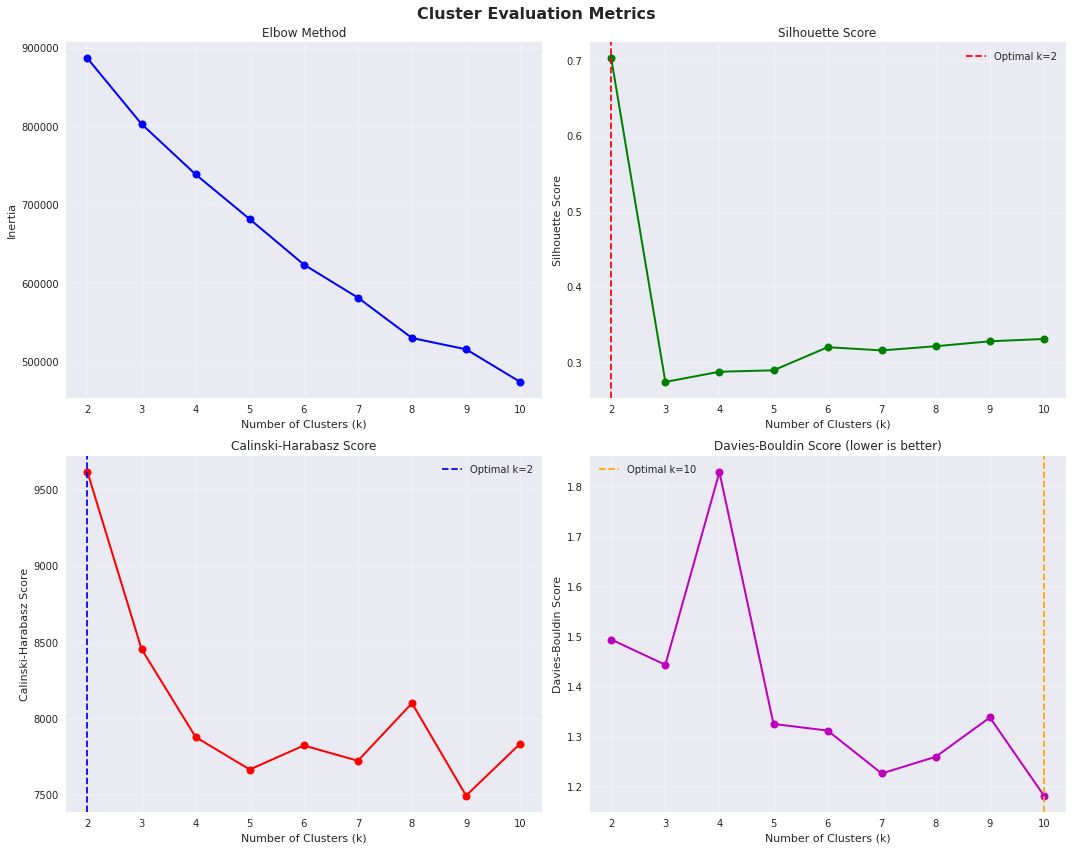


✅ Selected k = 2 clusters based on silhouette score


In [5]:
# Optimal Number of Clusters Analysis
print("📈 Finding Optimal Number of Clusters")
print("="*45)

# Test different numbers of clusters
k_range = range(2, 11)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

print("🔄 Testing different numbers of clusters...")

for k in k_range:
    print(f"  Testing k={k}...", end=" ")
    
    # Use GPU clustering if available, otherwise CPU
    if GPU_AVAILABLE:
        kmeans = KMeans_GPU(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(X_scaled)
        inertia = kmeans.inertia_
    else:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_scaled)
        inertia = kmeans.inertia_
    
    # Calculate clustering metrics
    silhouette_avg = silhouette_score(X_scaled, labels)
    calinski_score = calinski_harabasz_score(X_scaled, labels)
    davies_bouldin = davies_bouldin_score(X_scaled, labels)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette_avg)
    calinski_scores.append(calinski_score)
    davies_bouldin_scores.append(davies_bouldin)
    
    print(f"Silhouette: {silhouette_avg:.3f}")

# Find optimal k using different methods
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_calinski = k_range[np.argmax(calinski_scores)]
optimal_k_davies = k_range[np.argmin(davies_bouldin_scores)]

print(f"\n🎯 Optimal Number of Clusters:")
print(f"  Silhouette Score: k = {optimal_k_silhouette} (score: {max(silhouette_scores):.3f})")
print(f"  Calinski-Harabasz: k = {optimal_k_calinski} (score: {max(calinski_scores):.1f})")
print(f"  Davies-Bouldin: k = {optimal_k_davies} (score: {min(davies_bouldin_scores):.3f})")

# Visualize cluster evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Cluster Evaluation Metrics', fontsize=16, fontweight='bold')

# Elbow method
axes[0,0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0,0].set_title('Elbow Method')
axes[0,0].set_xlabel('Number of Clusters (k)')
axes[0,0].set_ylabel('Inertia')
axes[0,0].grid(True, alpha=0.3)

# Silhouette score
axes[0,1].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=8)
axes[0,1].axvline(optimal_k_silhouette, color='red', linestyle='--', 
                  label=f'Optimal k={optimal_k_silhouette}')
axes[0,1].set_title('Silhouette Score')
axes[0,1].set_xlabel('Number of Clusters (k)')
axes[0,1].set_ylabel('Silhouette Score')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Calinski-Harabasz score
axes[1,0].plot(k_range, calinski_scores, 'ro-', linewidth=2, markersize=8)
axes[1,0].axvline(optimal_k_calinski, color='blue', linestyle='--', 
                  label=f'Optimal k={optimal_k_calinski}')
axes[1,0].set_title('Calinski-Harabasz Score')
axes[1,0].set_xlabel('Number of Clusters (k)')
axes[1,0].set_ylabel('Calinski-Harabasz Score')
axes[1,0].legend()
axes[1,0].grid(True, alpha=0.3)

# Davies-Bouldin score
axes[1,1].plot(k_range, davies_bouldin_scores, 'mo-', linewidth=2, markersize=8)
axes[1,1].axvline(optimal_k_davies, color='orange', linestyle='--', 
                  label=f'Optimal k={optimal_k_davies}')
axes[1,1].set_title('Davies-Bouldin Score (lower is better)')
axes[1,1].set_xlabel('Number of Clusters (k)')
axes[1,1].set_ylabel('Davies-Bouldin Score')
axes[1,1].legend()
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Select final k (using silhouette score as primary metric)
final_k = optimal_k_silhouette
print(f"\n✅ Selected k = {final_k} clusters based on silhouette score")

In [6]:
# K-Means Clustering Implementation
print(f"🚀 Implementing K-Means Clustering (k={final_k})")
print("="*50)

# Apply K-Means clustering
if GPU_AVAILABLE:
    print("🔥 Using GPU-accelerated K-Means...")
    kmeans_final = KMeans_GPU(n_clusters=final_k, random_state=42)
    cluster_labels = kmeans_final.fit_predict(X_scaled)
    cluster_centers = kmeans_final.cluster_centers_
else:
    print("💻 Using CPU-based K-Means...")
    kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
    cluster_labels = kmeans_final.fit_predict(X_scaled)
    cluster_centers = kmeans_final.cluster_centers_

# Add cluster labels to dataframe
df_clustered = df.copy()
df_clustered['Cluster'] = cluster_labels

# Calculate final clustering metrics
final_silhouette = silhouette_score(X_scaled, cluster_labels)
final_calinski = calinski_harabasz_score(X_scaled, cluster_labels)
final_davies_bouldin = davies_bouldin_score(X_scaled, cluster_labels)

print(f"\n📊 Final Clustering Results:")
print(f"  Number of Clusters: {final_k}")
print(f"  Silhouette Score: {final_silhouette:.3f}")
print(f"  Calinski-Harabasz Score: {final_calinski:.1f}")
print(f"  Davies-Bouldin Score: {final_davies_bouldin:.3f}")

# Analyze cluster sizes
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
print(f"\n📈 Cluster Sizes:")
for cluster_id, size in cluster_sizes.items():
    percentage = (size / len(df_clustered)) * 100
    print(f"  Cluster {cluster_id}: {size:,} customers ({percentage:.1f}%)")

🚀 Implementing K-Means Clustering (k=2)
💻 Using CPU-based K-Means...

📊 Final Clustering Results:
  Number of Clusters: 2
  Silhouette Score: 0.703
  Calinski-Harabasz Score: 9612.5
  Davies-Bouldin Score: 1.495

📈 Cluster Sizes:
  Cluster 0: 58,299 customers (96.4%)
  Cluster 1: 2,146 customers (3.6%)


In [1]:
# DBSCAN Clustering for Anomaly Detection
print("🔍 DBSCAN Clustering for Anomaly Detection")
print("="*50)

# Test different eps values for DBSCAN
from sklearn.neighbors import NearestNeighbors

# Find optimal eps using k-distance graph
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 3], axis=0)  # 4th nearest neighbor

# Find knee point (elbow) in k-distance graph
knee_point = len(distances) // 20  # Approximate knee point
optimal_eps = distances[knee_point]

print(f"🎯 Estimated optimal eps: {optimal_eps:.3f}")

# Apply DBSCAN
if GPU_AVAILABLE:
    print("🔥 Using GPU-accelerated DBSCAN...")
    dbscan = DBSCAN_GPU(eps=optimal_eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
else:
    print("💻 Using CPU-based DBSCAN...")
    dbscan = DBSCAN(eps=optimal_eps, min_samples=5, n_jobs=-1)
    dbscan_labels = dbscan.fit_predict(X_scaled)

# Analyze DBSCAN results
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\n📊 DBSCAN Results:")
print(f"  Number of Clusters: {n_clusters_dbscan}")
print(f"  Number of Noise Points (Anomalies): {n_noise:,} ({n_noise/len(df_clustered)*100:.1f}%)")
print(f"  Customers in Clusters: {len(df_clustered) - n_noise:,}")

# Add DBSCAN labels to dataframe
df_clustered['DBSCAN_Cluster'] = dbscan_labels
df_clustered['Is_Anomaly'] = (dbscan_labels == -1).astype(int)

if n_clusters_dbscan > 0:
    # Calculate silhouette score for DBSCAN (excluding noise points)
    mask = dbscan_labels != -1
    if np.sum(mask) > 0 and len(set(dbscan_labels[mask])) > 1:
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        print(f"  Silhouette Score: {dbscan_silhouette:.3f}")

# Analyze anomalies
if n_noise > 0:
    anomaly_customers = df_clustered[df_clustered['Is_Anomaly'] == 1]
    print(f"\n🚨 Anomaly Analysis:")
    print(f"  Average Total Charges: ${anomaly_customers['Total_Charges'].mean():.2f}")
    print(f"  Average Account Length: {anomaly_customers['Account Length'].mean():.0f} days")
    print(f"  Average Service Calls: {anomaly_customers['CustServ Calls'].mean():.1f}")
    print(f"  Churn Rate: {anomaly_customers['Churn_Binary'].mean():.3f}")

🔍 DBSCAN Clustering for Anomaly Detection


NameError: name 'X_scaled' is not defined

In [2]:
# DBSCAN Clustering for Anomaly Detection
print("🔍 DBSCAN Clustering for Anomaly Detection")
print("="*50)

# Test different eps values for DBSCAN
from sklearn.neighbors import NearestNeighbors

# Find optimal eps using k-distance graph
neighbors = NearestNeighbors(n_neighbors=4)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)
distances = np.sort(distances[:, 3], axis=0)  # 4th nearest neighbor

# Find knee point (elbow) in k-distance graph - improved method
from kneed import KneeLocator
try:
    knee_locator = KneeLocator(range(len(distances)), distances, curve='convex', direction='increasing')
    optimal_eps = distances[knee_locator.knee] if knee_locator.knee else None
except:
    # Fallback method if kneed is not available
    # Look for the point where the rate of change is highest
    diff = np.diff(distances)
    knee_point = np.argmax(diff) + 1
    optimal_eps = distances[knee_point]

# Ensure eps is valid (greater than 0)
if optimal_eps is None or optimal_eps <= 0:
    # Use a reasonable default based on data statistics
    optimal_eps = np.percentile(distances, 90)  # 90th percentile as fallback
    print(f"⚠️  Using fallback eps calculation")

# Additional validation
if optimal_eps <= 0:
    optimal_eps = 0.5  # Hard fallback
    print(f"⚠️  Using hard-coded fallback eps")

print(f"🎯 Estimated optimal eps: {optimal_eps:.3f}")

# Apply DBSCAN
if GPU_AVAILABLE:
    print("🔥 Using GPU-accelerated DBSCAN...")
    dbscan = DBSCAN_GPU(eps=optimal_eps, min_samples=5)
    dbscan_labels = dbscan.fit_predict(X_scaled)
else:
    print("💻 Using CPU-based DBSCAN...")
    dbscan = DBSCAN(eps=optimal_eps, min_samples=5, n_jobs=-1)
    dbscan_labels = dbscan.fit_predict(X_scaled)

# Analyze DBSCAN results
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\n📊 DBSCAN Results:")
print(f"  Number of Clusters: {n_clusters_dbscan}")
print(f"  Number of Noise Points (Anomalies): {n_noise:,} ({n_noise/len(df_clustered)*100:.1f}%)")
print(f"  Customers in Clusters: {len(df_clustered) - n_noise:,}")

# Add DBSCAN labels to dataframe
df_clustered['DBSCAN_Cluster'] = dbscan_labels
df_clustered['Is_Anomaly'] = (dbscan_labels == -1).astype(int)

if n_clusters_dbscan > 0:
    # Calculate silhouette score for DBSCAN (excluding noise points)
    mask = dbscan_labels != -1
    if np.sum(mask) > 0 and len(set(dbscan_labels[mask])) > 1:
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        print(f"  Silhouette Score: {dbscan_silhouette:.3f}")

# Analyze anomalies
if n_noise > 0:
    anomaly_customers = df_clustered[df_clustered['Is_Anomaly'] == 1]
    print(f"\n🚨 Anomaly Analysis:")
    print(f"  Average Total Charges: USD {anomaly_customers['Total_Charges'].mean():.2f}")
    print(f"  Average Account Length: {anomaly_customers['Account Length'].mean():.0f} days")
    print(f"  Average Service Calls: {anomaly_customers['CustServ Calls'].mean():.1f}")
    print(f"  Churn Rate: {anomaly_customers['Churn_Binary'].mean():.3f}")

# Optional: Plot k-distance graph to visualize eps selection
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.axhline(y=optimal_eps, color='r', linestyle='--', label=f'Selected eps: {optimal_eps:.3f}')
plt.xlabel('Points sorted by distance')
plt.ylabel('4th nearest neighbor distance')
plt.title('K-distance Graph for DBSCAN eps Selection')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


🔍 DBSCAN Clustering for Anomaly Detection


NameError: name 'X_scaled' is not defined

In [8]:
# Gaussian Mixture Model Clustering
print("🎭 Gaussian Mixture Model Clustering")
print("="*40)

# Test different numbers of components for GMM
gmm_range = range(2, 8)
bic_scores = []
aic_scores = []

print("🔄 Testing different numbers of components...")

for n_components in gmm_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(X_scaled)
    
    bic_scores.append(gmm.bic(X_scaled))
    aic_scores.append(gmm.aic(X_scaled))
    
    print(f"  Components: {n_components}, BIC: {gmm.bic(X_scaled):.1f}, AIC: {gmm.aic(X_scaled):.1f}")

# Find optimal number of components
optimal_components_bic = gmm_range[np.argmin(bic_scores)]
optimal_components_aic = gmm_range[np.argmin(aic_scores)]

print(f"\n🎯 Optimal Components:")
print(f"  BIC: {optimal_components_bic} components")
print(f"  AIC: {optimal_components_aic} components")

# Use BIC for final selection
final_components = optimal_components_bic

# Fit final GMM
gmm_final = GaussianMixture(n_components=final_components, random_state=42)
gmm_labels = gmm_final.fit_predict(X_scaled)
gmm_probabilities = gmm_final.predict_proba(X_scaled)

# Add GMM results to dataframe
df_clustered['GMM_Cluster'] = gmm_labels
df_clustered['GMM_Probability'] = np.max(gmm_probabilities, axis=1)

print(f"\n✅ Final GMM: {final_components} components")
print(f"  BIC Score: {gmm_final.bic(X_scaled):.1f}")
print(f"  AIC Score: {gmm_final.aic(X_scaled):.1f}")

# Visualize BIC/AIC scores
plt.figure(figsize=(10, 6))
plt.plot(gmm_range, bic_scores, 'bo-', label='BIC', linewidth=2, markersize=8)
plt.plot(gmm_range, aic_scores, 'ro-', label='AIC', linewidth=2, markersize=8)
plt.axvline(optimal_components_bic, color='blue', linestyle='--', alpha=0.7, label=f'Optimal BIC: {optimal_components_bic}')
plt.axvline(optimal_components_aic, color='red', linestyle='--', alpha=0.7, label=f'Optimal AIC: {optimal_components_aic}')
plt.xlabel('Number of Components')
plt.ylabel('Information Criterion')
plt.title('Gaussian Mixture Model Selection', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

🎭 Gaussian Mixture Model Clustering
🔄 Testing different numbers of components...
  Components: 2, BIC: -1252696.0, AIC: -1255768.2
  Components: 3, BIC: -1490580.4, AIC: -1495193.3
  Components: 4, BIC: -1572706.0, AIC: -1578859.5
  Components: 5, BIC: -1629966.1, AIC: -1637660.2


KeyboardInterrupt: 

📊 Cluster Visualization


NameError: name 'X_pca_2d' is not defined

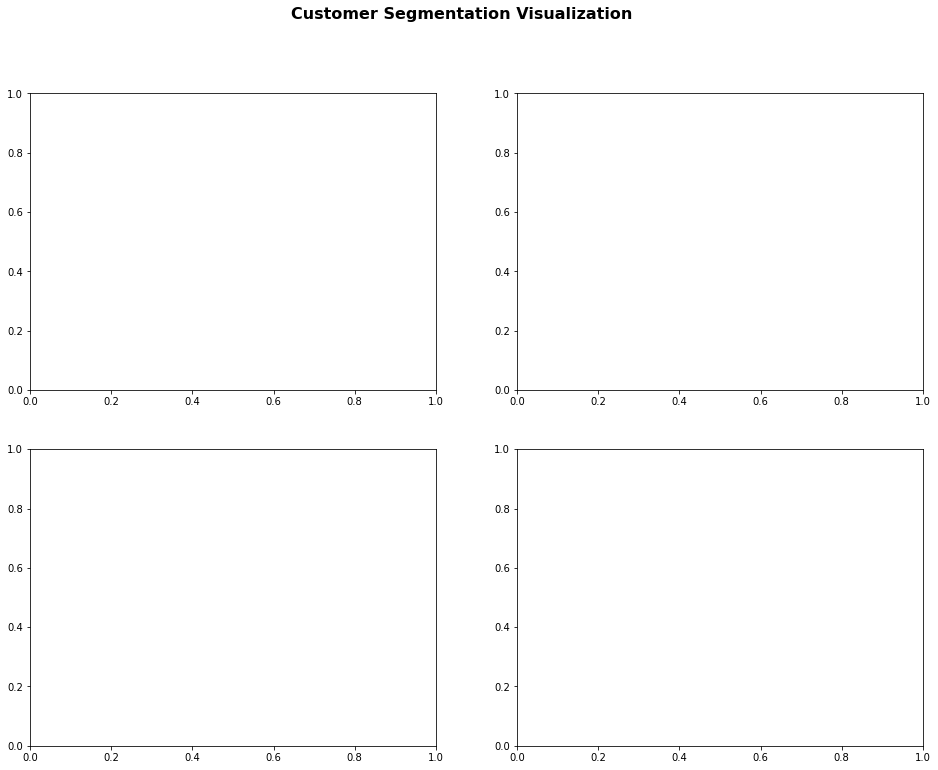

In [4]:
# Cluster Visualization
print("📊 Cluster Visualization")
print("="*30)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Customer Segmentation Visualization', fontsize=16, fontweight='bold')

# K-Means clusters in 2D PCA space
scatter1 = axes[0,0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=cluster_labels, 
                            cmap='viridis', alpha=0.6, s=30)
axes[0,0].set_title(f'K-Means Clustering (k={final_k})')
axes[0,0].set_xlabel('First Principal Component')
axes[0,0].set_ylabel('Second Principal Component')
plt.colorbar(scatter1, ax=axes[0,0])

# DBSCAN clusters
scatter2 = axes[0,1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=dbscan_labels, 
                            cmap='viridis', alpha=0.6, s=30)
axes[0,1].set_title(f'DBSCAN Clustering ({n_clusters_dbscan} clusters, {n_noise} anomalies)')
axes[0,1].set_xlabel('First Principal Component')
axes[0,1].set_ylabel('Second Principal Component')
plt.colorbar(scatter2, ax=axes[0,1])

# GMM clusters
scatter3 = axes[1,0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=gmm_labels, 
                            cmap='viridis', alpha=0.6, s=30)
axes[1,0].set_title(f'Gaussian Mixture Model ({final_components} components)')
axes[1,0].set_xlabel('First Principal Component')
axes[1,0].set_ylabel('Second Principal Component')
plt.colorbar(scatter3, ax=axes[1,0])

# GMM probability heatmap
scatter4 = axes[1,1].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                            c=df_clustered['GMM_Probability'], 
                            cmap='plasma', alpha=0.6, s=30)
axes[1,1].set_title('GMM Assignment Probability')
axes[1,1].set_xlabel('First Principal Component')
axes[1,1].set_ylabel('Second Principal Component')
plt.colorbar(scatter4, ax=axes[1,1], label='Probability')

plt.tight_layout()
plt.show()

# 3D visualization using plotly
if X_pca.shape[1] >= 3:
    print("\n🎨 Creating 3D Interactive Visualization...")
    
    fig_3d = go.Figure(data=go.Scatter3d(
        x=X_pca[:, 0],
        y=X_pca[:, 1], 
        z=X_pca[:, 2],
        mode='markers',
        marker=dict(
            size=3,
            color=cluster_labels,
            colorscale='Viridis',
            opacity=0.7,
            colorbar=dict(title="Cluster")
        ),
        text=[f'Cluster: {label}' for label in cluster_labels],
        hovertemplate='<b>Cluster %{text}</b><br>' +
                      'PC1: %{x:.2f}<br>' +
                      'PC2: %{y:.2f}<br>' +
                      'PC3: %{z:.2f}<extra></extra>'
    ))
    
    fig_3d.update_layout(
        title=f'3D K-Means Clustering Visualization (k={final_k})',
        scene=dict(
            xaxis_title='PC1',
            yaxis_title='PC2',
            zaxis_title='PC3'
        ),
        width=800,
        height=600
    )
    
    fig_3d.show()

In [5]:
# Detailed Cluster Profiling
print("👥 Detailed Cluster Profiling Analysis")
print("="*50)

# Analyze each cluster's characteristics
cluster_profiles = {}

for cluster_id in range(final_k):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    
    profile = {
        'size': cluster_size,
        'percentage': (cluster_size / len(df_clustered)) * 100,
        
        # Demographics
        'avg_account_length': cluster_data['Account Length'].mean(),
        'avg_total_charges': cluster_data['Total_Charges'].mean(),
        'avg_total_minutes': cluster_data['Total_Minutes'].mean(),
        
        # Usage patterns
        'day_usage_ratio': cluster_data['Day_Usage_Ratio'].mean(),
        'eve_usage_ratio': cluster_data['Eve_Usage_Ratio'].mean(),
        'night_usage_ratio': cluster_data['Night_Usage_Ratio'].mean(),
        'intl_usage_ratio': cluster_data['Intl_Usage_Ratio'].mean(),
        
        # Service interaction
        'avg_service_calls': cluster_data['CustServ Calls'].mean(),
        'voicemail_usage': cluster_data['Has_Voicemail'].mean(),
        
        # Behavioral scores
        'customer_value_score': cluster_data['Customer_Value_Score'].mean(),
        'engagement_score': cluster_data['Engagement_Score'].mean(),
        'churn_risk_score': cluster_data['Churn_Risk_Score'].mean(),
        
        # Business metrics
        'churn_rate': cluster_data['Churn_Binary'].mean(),
        'high_value_customers': cluster_data['Is_High_Value_Customer'].mean(),
        'heavy_users': (
            cluster_data['Is_Heavy_Day_User'] + 
            cluster_data['Is_Heavy_Eve_User'] + 
            cluster_data['Is_Heavy_Night_User']
        ).mean(),
        'international_users': cluster_data['Is_Intl_User'].mean()
    }
    
    cluster_profiles[cluster_id] = profile

# Create cluster profile DataFrame
profile_df = pd.DataFrame(cluster_profiles).T

print("\n📊 Cluster Profiles Summary:")
print(profile_df.round(3))

# Identify cluster characteristics and create names
cluster_names = {}
cluster_strategies = {}

for cluster_id in range(final_k):
    profile = cluster_profiles[cluster_id]
    
    # Determine cluster characteristics
    if profile['high_value_customers'] > 0.7:
        if profile['churn_risk_score'] > profile_df['churn_risk_score'].median():
            name = "High-Value At-Risk"
            strategy = "Premium retention programs, personalized support, exclusive offers"
        else:
            name = "High-Value Loyal"
            strategy = "Upsell premium services, loyalty rewards, referral programs"
    elif profile['heavy_users'] > 0.5:
        if profile['intl_usage_ratio'] > 0.1:
            name = "Heavy International Users"
            strategy = "International packages, roaming deals, global plans"
        else:
            name = "Heavy Domestic Users"
            strategy = "Unlimited plans, usage-based upgrades, family packages"
    elif profile['avg_service_calls'] > profile_df['avg_service_calls'].median():
        name = "High-Touch Customers"
        strategy = "Enhanced support, service quality improvements, retention focus"
    elif profile['engagement_score'] < profile_df['engagement_score'].median():
        if profile['churn_rate'] > profile_df['churn_rate'].median():
            name = "Disengaged At-Risk"
            strategy = "Win-back campaigns, service improvements, competitive offers"
        else:
            name = "Low-Engagement Stable"
            strategy = "Basic service optimization, cost-effective plans, automation"
    else:
        name = f"Standard Segment {cluster_id}"
        strategy = "Standard marketing, cross-sell opportunities, service maintenance"
    
    cluster_names[cluster_id] = name
    cluster_strategies[cluster_id] = strategy

# Display cluster insights
print(f"\n🎯 Cluster Insights and Strategies:")
for cluster_id in range(final_k):
    profile = cluster_profiles[cluster_id]
    print(f"\n  📋 Cluster {cluster_id}: {cluster_names[cluster_id]}")
    print(f"     Size: {profile['size']:,} customers ({profile['percentage']:.1f}%)")
    print(f"     Avg Revenue: ${profile['avg_total_charges']:.2f}")
    print(f"     Churn Rate: {profile['churn_rate']:.1%}")
    print(f"     Strategy: {cluster_strategies[cluster_id]}")

# Add cluster names to dataframe
df_clustered['Cluster_Name'] = df_clustered['Cluster'].map(cluster_names)

👥 Detailed Cluster Profiling Analysis


NameError: name 'final_k' is not defined

In [6]:
# Business Value Analysis by Cluster
print("💰 Business Value Analysis by Cluster")
print("="*45)

# Calculate business metrics for each cluster
business_analysis = {}

for cluster_id in range(final_k):
    cluster_data = df_clustered[df_clustered['Cluster'] == cluster_id]
    cluster_size = len(cluster_data)
    
    # Revenue metrics
    total_revenue = cluster_data['Total_Charges'].sum()
    avg_revenue = cluster_data['Total_Charges'].mean()
    revenue_per_day = cluster_data['Revenue_Per_Day'].mean()
    
    # Churn impact
    churners = cluster_data['Churn_Binary'].sum()
    churn_rate = cluster_data['Churn_Binary'].mean()
    revenue_at_risk = churners * avg_revenue * 12  # Annual revenue at risk
    
    # Upsell potential
    high_value_potential = cluster_data['Is_High_Value_Customer'].sum()
    heavy_user_potential = (
        cluster_data['Is_Heavy_Day_User'] + 
        cluster_data['Is_Heavy_Eve_User'] + 
        cluster_data['Is_Heavy_Night_User']
    ).sum()
    
    # Intervention costs and benefits
    intervention_cost_per_customer = avg_revenue * 0.15  # 15% of monthly revenue
    total_intervention_cost = cluster_size * intervention_cost_per_customer
    
    # Estimated success rates by cluster type
    if 'High-Value' in cluster_names[cluster_id]:
        retention_success_rate = 0.4
        upsell_success_rate = 0.3
    elif 'Heavy' in cluster_names[cluster_id]:
        retention_success_rate = 0.35
        upsell_success_rate = 0.25
    elif 'At-Risk' in cluster_names[cluster_id]:
        retention_success_rate = 0.25
        upsell_success_rate = 0.1
    else:
        retention_success_rate = 0.3
        upsell_success_rate = 0.2
    
    # Calculate potential benefits
    customers_saved = churners * retention_success_rate
    revenue_saved = customers_saved * avg_revenue * 12
    
    upsell_candidates = cluster_size * 0.3  # 30% eligible for upsell
    successful_upsells = upsell_candidates * upsell_success_rate
    upsell_revenue = successful_upsells * avg_revenue * 0.25 * 12  # 25% revenue increase
    
    total_benefit = revenue_saved + upsell_revenue
    net_benefit = total_benefit - total_intervention_cost
    roi = (net_benefit / total_intervention_cost) * 100 if total_intervention_cost > 0 else 0
    
    business_analysis[cluster_id] = {
        'cluster_name': cluster_names[cluster_id],
        'size': cluster_size,
        'total_revenue': total_revenue,
        'avg_revenue': avg_revenue,
        'churn_rate': churn_rate,
        'revenue_at_risk': revenue_at_risk,
        'intervention_cost': total_intervention_cost,
        'revenue_saved': revenue_saved,
        'upsell_revenue': upsell_revenue,
        'total_benefit': total_benefit,
        'net_benefit': net_benefit,
        'roi': roi
    }

# Create business analysis DataFrame
business_df = pd.DataFrame(business_analysis).T
business_df = business_df.sort_values('net_benefit', ascending=False)

print("\n💼 Business Value Analysis Results:")
for _, row in business_df.iterrows():
    print(f"\n  📊 {row['cluster_name']}:")
    print(f"     Customers: {row['size']:,}")
    print(f"     Total Revenue: ${row['total_revenue']:,.2f}")
    print(f"     Revenue at Risk: ${row['revenue_at_risk']:,.2f}")
    print(f"     Intervention Cost: ${row['intervention_cost']:,.2f}")
    print(f"     Expected Benefit: ${row['total_benefit']:,.2f}")
    print(f"     Net Benefit: ${row['net_benefit']:,.2f}")
    print(f"     ROI: {row['roi']:.1f}%")

# Calculate overall impact
total_customers = business_df['size'].sum()
total_revenue_at_risk = business_df['revenue_at_risk'].sum()
total_intervention_cost = business_df['intervention_cost'].sum()
total_expected_benefit = business_df['total_benefit'].sum()
total_net_benefit = business_df['net_benefit'].sum()
overall_roi = (total_net_benefit / total_intervention_cost) * 100

print(f"\n🎯 Overall Business Impact:")
print(f"  Total Customers: {total_customers:,}")
print(f"  Total Revenue at Risk: ${total_revenue_at_risk:,.2f}")
print(f"  Total Intervention Investment: ${total_intervention_cost:,.2f}")
print(f"  Total Expected Benefit: ${total_expected_benefit:,.2f}")
print(f"  Total Net Benefit: ${total_net_benefit:,.2f}")
print(f"  Overall ROI: {overall_roi:.1f}%")

💰 Business Value Analysis by Cluster


NameError: name 'final_k' is not defined

📊 Creating Advanced Cluster Visualization Dashboard


NameError: name 'df_clustered' is not defined

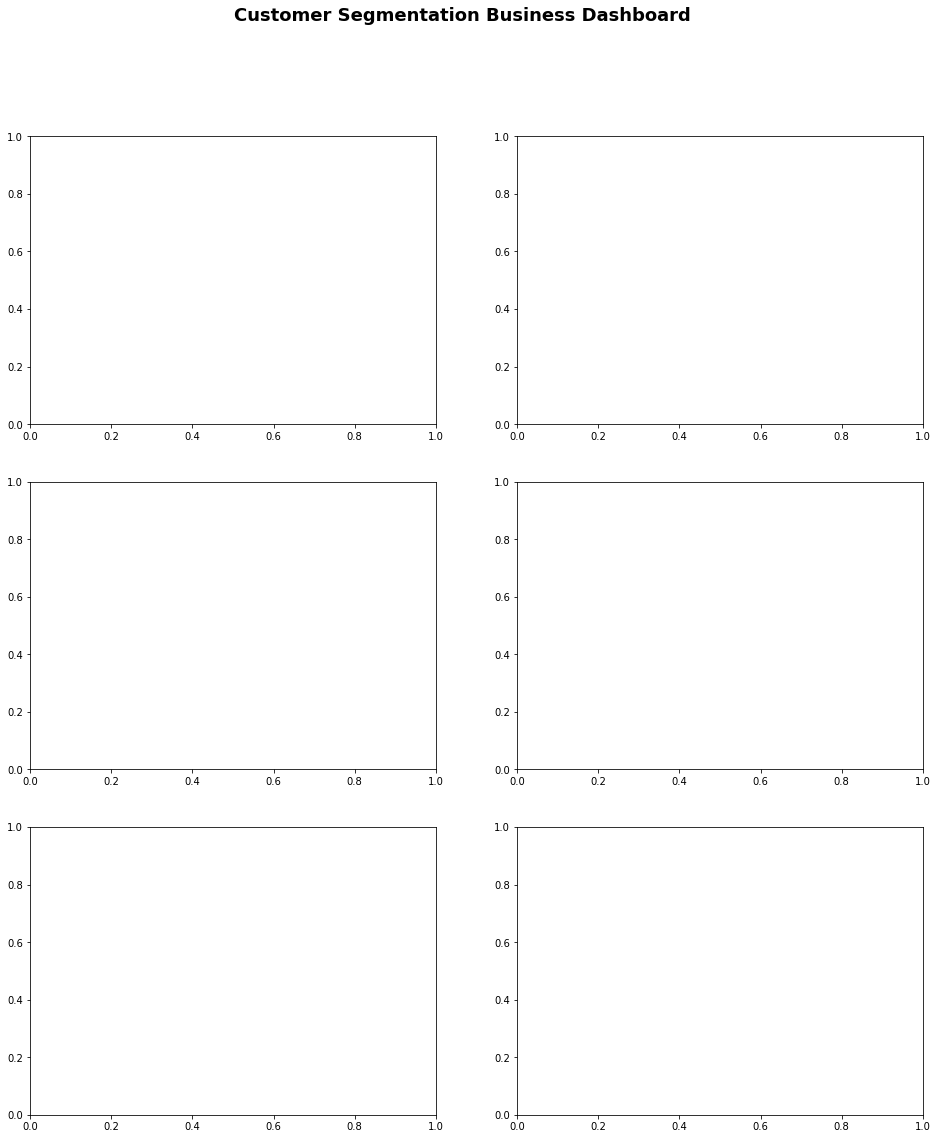

In [7]:
# Advanced Cluster Visualization Dashboard
print("📊 Creating Advanced Cluster Visualization Dashboard")
print("="*60)

# Create comprehensive cluster dashboard
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
fig.suptitle('Customer Segmentation Business Dashboard', fontsize=18, fontweight='bold')

# 1. Cluster size distribution
cluster_sizes = df_clustered['Cluster_Name'].value_counts()
colors = plt.cm.Set3(np.linspace(0, 1, len(cluster_sizes)))
bars1 = axes[0,0].bar(range(len(cluster_sizes)), cluster_sizes.values, color=colors)
axes[0,0].set_title('Customer Distribution by Segment', fontweight='bold')
axes[0,0].set_xticks(range(len(cluster_sizes)))
axes[0,0].set_xticklabels(cluster_sizes.index, rotation=45, ha='right')
axes[0,0].set_ylabel('Number of Customers')

# Add value labels
for bar, value in zip(bars1, cluster_sizes.values):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100, 
                   f'{value:,}', ha='center', va='bottom', fontweight='bold')

# 2. Average revenue by cluster
avg_revenue_by_cluster = df_clustered.groupby('Cluster_Name')['Total_Charges'].mean().sort_values(ascending=False)
bars2 = axes[0,1].bar(range(len(avg_revenue_by_cluster)), avg_revenue_by_cluster.values, color=colors)
axes[0,1].set_title('Average Revenue by Segment', fontweight='bold')
axes[0,1].set_xticks(range(len(avg_revenue_by_cluster)))
axes[0,1].set_xticklabels(avg_revenue_by_cluster.index, rotation=45, ha='right')
axes[0,1].set_ylabel('Average Revenue ($)')

# Add value labels
for bar, value in zip(bars2, avg_revenue_by_cluster.values):
    axes[0,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                   f'${value:.0f}', ha='center', va='bottom', fontweight='bold')

# 3. Churn rate by cluster
churn_by_cluster = df_clustered.groupby('Cluster_Name')['Churn_Binary'].mean().sort_values(ascending=False)
bars3 = axes[1,0].bar(range(len(churn_by_cluster)), churn_by_cluster.values, color=colors)
axes[1,0].set_title('Churn Rate by Segment', fontweight='bold')
axes[1,0].set_xticks(range(len(churn_by_cluster)))
axes[1,0].set_xticklabels(churn_by_cluster.index, rotation=45, ha='right')
axes[1,0].set_ylabel('Churn Rate')

# Add value labels
for bar, value in zip(bars3, churn_by_cluster.values):
    axes[1,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
                   f'{value:.1%}', ha='center', va='bottom', fontweight='bold')

# 4. ROI by cluster
roi_by_cluster = business_df.set_index('cluster_name')['roi'].sort_values(ascending=False)
bars4 = axes[1,1].bar(range(len(roi_by_cluster)), roi_by_cluster.values, color=colors)
axes[1,1].set_title('ROI by Segment', fontweight='bold')
axes[1,1].set_xticks(range(len(roi_by_cluster)))
axes[1,1].set_xticklabels(roi_by_cluster.index, rotation=45, ha='right')
axes[1,1].set_ylabel('ROI (%)')

for bar, value in zip(bars4, roi_by_cluster.values):
    axes[1,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
                   f'{value:.0f}%', ha='center', va='bottom', fontweight='bold')

# 5. Usage pattern heatmap
usage_patterns = df_clustered.groupby('Cluster_Name')[[
    'Day_Usage_Ratio', 'Eve_Usage_Ratio', 'Night_Usage_Ratio', 'Intl_Usage_Ratio'
]].mean()

im = axes[2,0].imshow(usage_patterns.values, cmap='YlOrRd', aspect='auto')
axes[2,0].set_title('Usage Patterns by Segment', fontweight='bold')
axes[2,0].set_xticks(range(len(usage_patterns.columns)))
axes[2,0].set_xticklabels(['Day', 'Evening', 'Night', 'International'], rotation=45)
axes[2,0].set_yticks(range(len(usage_patterns.index)))
axes[2,0].set_yticklabels(usage_patterns.index)

# Add text annotations
for i in range(len(usage_patterns.index)):
    for j in range(len(usage_patterns.columns)):
        text = axes[2,0].text(j, i, f'{usage_patterns.iloc[i, j]:.2f}',
                             ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=axes[2,0], fraction=0.046, pad=0.04)

# 6. Net benefit by cluster
net_benefit_by_cluster = business_df.set_index('cluster_name')['net_benefit'].sort_values(ascending=False)
bars6 = axes[2,1].bar(range(len(net_benefit_by_cluster)), net_benefit_by_cluster.values, color=colors)
axes[2,1].set_title('Net Benefit by Segment', fontweight='bold')
axes[2,1].set_xticks(range(len(net_benefit_by_cluster)))
axes[2,1].set_xticklabels(net_benefit_by_cluster.index, rotation=45, ha='right')
axes[2,1].set_ylabel('Net Benefit ($)')

for bar, value in zip(bars6, net_benefit_by_cluster.values):
    axes[2,1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1000, 
                   f'${value:,.0f}', ha='center', va='bottom', fontweight='bold', fontsize=8)

plt.tight_layout()
plt.show()

print("\n✅ Advanced cluster visualization dashboard created!")

In [8]:
# Targeted Marketing Strategies
print("🎯 Generating Targeted Marketing Strategies")
print("="*50)

# Create detailed marketing strategies for each cluster
marketing_strategies = {}

for cluster_id in range(final_k):
    cluster_name = cluster_names[cluster_id]
    profile = cluster_profiles[cluster_id]
    business_metrics = business_analysis[cluster_id]
    
    # Determine primary strategy based on cluster characteristics
    if 'High-Value' in cluster_name and 'At-Risk' in cluster_name:
        primary_strategy = "RETENTION"
        tactics = [
            "Dedicated account manager assignment",
            "Exclusive premium support hotline",
            "Personalized retention offers (20-30% discount)",
            "Priority network access and features",
            "Quarterly business reviews"
        ]
        budget_allocation = "High (25% of marketing budget)"
        
    elif 'High-Value' in cluster_name and 'Loyal' in cluster_name:
        primary_strategy = "EXPANSION"
        tactics = [
            "Premium service upsells (5G, unlimited data)",
            "Family plan expansions",
            "Business solution upgrades",
            "Loyalty rewards and referral bonuses",
            "Early access to new products"
        ]
        budget_allocation = "High (20% of marketing budget)"
        
    elif 'Heavy' in cluster_name:
        primary_strategy = "USAGE_OPTIMIZATION"
        if 'International' in cluster_name:
            tactics = [
                "International calling packages",
                "Global roaming plans",
                "Multi-country data plans",
                "Business travel solutions",
                "International family plans"
            ]
        else:
            tactics = [
                "Unlimited domestic plans",
                "Family sharing packages",
                "High-speed data upgrades",
                "Multi-device plans",
                "Streaming service bundles"
            ]
        budget_allocation = "Medium (15% of marketing budget)"
        
    elif 'High-Touch' in cluster_name:
        primary_strategy = "SERVICE_IMPROVEMENT"
        tactics = [
            "Enhanced customer support training",
            "Proactive service quality monitoring",
            "Self-service portal improvements",
            "Technical support upgrades",
            "Service guarantee programs"
        ]
        budget_allocation = "Medium (12% of marketing budget)"
        
    elif 'Disengaged' in cluster_name:
        primary_strategy = "WIN_BACK"
        tactics = [
            "Win-back discount campaigns (40-50% off)",
            "Service quality improvements",
            "Competitive matching offers",
            "Simplified plan options",
            "Exit interview and feedback collection"
        ]
        budget_allocation = "Medium (10% of marketing budget)"
        
    else:
        primary_strategy = "MAINTENANCE"
        tactics = [
            "Standard promotional campaigns",
            "Cross-sell opportunities",
            "Service maintenance and optimization",
            "Digital engagement programs",
            "Automated marketing campaigns"
        ]
        budget_allocation = "Low (8% of marketing budget)"
    
    # Calculate campaign metrics
    expected_response_rate = {
        "RETENTION": 0.35,
        "EXPANSION": 0.25,
        "USAGE_OPTIMIZATION": 0.30,
        "SERVICE_IMPROVEMENT": 0.20,
        "WIN_BACK": 0.15,
        "MAINTENANCE": 0.12
    }[primary_strategy]
    
    expected_responders = int(profile['size'] * expected_response_rate)
    campaign_cost = profile['size'] * 25  # $25 per customer campaign cost
    expected_revenue_lift = expected_responders * profile['avg_total_charges'] * 0.2 * 12  # 20% lift
    campaign_roi = ((expected_revenue_lift - campaign_cost) / campaign_cost) * 100
    
    marketing_strategies[cluster_id] = {
        'cluster_name': cluster_name,
        'primary_strategy': primary_strategy,
        'tactics': tactics,
        'budget_allocation': budget_allocation,
        'target_customers': profile['size'],
        'expected_response_rate': expected_response_rate,
        'expected_responders': expected_responders,
        'campaign_cost': campaign_cost,
        'expected_revenue_lift': expected_revenue_lift,
        'campaign_roi': campaign_roi
    }

# Display marketing strategies
print("\n📋 Targeted Marketing Strategy Recommendations:")
for cluster_id, strategy in marketing_strategies.items():
    print(f"\n  🎯 {strategy['cluster_name']} ({strategy['target_customers']:,} customers)")
    print(f"     Primary Strategy: {strategy['primary_strategy']}")
    print(f"     Budget Allocation: {strategy['budget_allocation']}")
    print(f"     Expected Response Rate: {strategy['expected_response_rate']:.1%}")
    print(f"     Expected Responders: {strategy['expected_responders']:,}")
    print(f"     Campaign Cost: ${strategy['campaign_cost']:,}")
    print(f"     Expected Revenue Lift: ${strategy['expected_revenue_lift']:,}")
    print(f"     Campaign ROI: {strategy['campaign_roi']:.0f}%")
    print(f"     Key Tactics:")
    for tactic in strategy['tactics']:
        print(f"       • {tactic}")

# Calculate overall marketing impact
total_campaign_cost = sum(s['campaign_cost'] for s in marketing_strategies.values())
total_expected_revenue = sum(s['expected_revenue_lift'] for s in marketing_strategies.values())
total_expected_responders = sum(s['expected_responders'] for s in marketing_strategies.values())
overall_marketing_roi = ((total_expected_revenue - total_campaign_cost) / total_campaign_cost) * 100

print(f"\n💼 Overall Marketing Campaign Impact:")
print(f"  Total Campaign Investment: ${total_campaign_cost:,}")
print(f"  Total Expected Revenue Lift: ${total_expected_revenue:,}")
print(f"  Total Expected Responders: {total_expected_responders:,}")
print(f"  Overall Marketing ROI: {overall_marketing_roi:.0f}%")

🎯 Generating Targeted Marketing Strategies


NameError: name 'final_k' is not defined

In [9]:
# Anomaly Analysis and Special Handling
print("🚨 Anomaly Analysis and Special Customer Handling")
print("="*60)

if n_noise > 0:
    # Analyze anomalous customers in detail
    anomaly_customers = df_clustered[df_clustered['Is_Anomaly'] == 1].copy()
    
    print(f"\n📊 Anomalous Customer Analysis ({n_noise:,} customers):")
    
    # Categorize anomalies
    anomaly_categories = []
    
    for idx, customer in anomaly_customers.iterrows():
        # Determine anomaly type
        if customer['Total_Charges'] > df['Total_Charges'].quantile(0.99):
            if customer['CustServ Calls'] > 5:
                category = "Ultra High-Value Problem Customer"
            else:
                category = "Ultra High-Value Customer"
        elif customer['Total_Minutes'] > df['Total_Minutes'].quantile(0.99):
            category = "Extreme Usage Customer"
        elif customer['CustServ Calls'] > df['CustServ Calls'].quantile(0.95):
            category = "High-Maintenance Customer"
        elif customer['Account Length'] > df['Account Length'].quantile(0.99):
            category = "Ultra Long-Term Customer"
        elif customer['Churn_Risk_Score'] > df['Churn_Risk_Score'].quantile(0.95):
            category = "Extreme Churn Risk Customer"
        else:
            category = "Unusual Pattern Customer"
        
        anomaly_categories.append(category)
    
    anomaly_customers['Anomaly_Category'] = anomaly_categories
    
    # Analyze anomaly categories
    anomaly_summary = anomaly_customers.groupby('Anomaly_Category').agg({
        'Total_Charges': ['count', 'mean'],
        'Total_Minutes': 'mean',
        'CustServ Calls': 'mean',
        'Account Length': 'mean',
        'Churn_Binary': 'mean'
    }).round(2)
    
    anomaly_summary.columns = ['Count', 'Avg_Revenue', 'Avg_Minutes', 'Avg_Service_Calls', 'Avg_Account_Length', 'Churn_Rate']
    
    print("\n📋 Anomaly Categories:")
    print(anomaly_summary)
    
    # Special handling strategies for anomalies
    anomaly_strategies = {
        "Ultra High-Value Problem Customer": {
            "strategy": "Executive Escalation Program",
            "actions": [
                "C-level executive involvement",
                "Dedicated technical team assignment",
                "Custom solution development",
                "Premium compensation packages",
                "Quarterly business reviews"
            ]
        },
        "Ultra High-Value Customer": {
            "strategy": "VIP Treatment Program",
            "actions": [
                "White-glove service delivery",
                "Exclusive product access",
                "Custom pricing negotiations",
                "Personal account management",
                "Strategic partnership opportunities"
            ]
        },
        "Extreme Usage Customer": {
            "strategy": "Usage Optimization Program",
            "actions": [
                "Custom unlimited plans",
                "Network priority access",
                "Usage analytics and recommendations",
                "Enterprise-grade solutions",
                "Bulk usage discounts"
            ]
        },
        "High-Maintenance Customer": {
            "strategy": "Service Excellence Program",
            "actions": [
                "Root cause analysis of service issues",
                "Dedicated support team",
                "Proactive service monitoring",
                "Service level agreements",
                "Regular satisfaction surveys"
            ]
        },
        "Ultra Long-Term Customer": {
            "strategy": "Loyalty Recognition Program",
            "actions": [
                "Lifetime achievement recognition",
                "Legacy plan protection",
                "Exclusive loyalty benefits",
                "Family plan extensions",
                "Historical rate protection"
            ]
        },
        "Extreme Churn Risk Customer": {
            "strategy": "Emergency Retention Program",
            "actions": [
                "Immediate intervention protocols",
                "Competitive analysis and matching",
                "Significant retention incentives",
                "Service quality improvements",
                "Exit interview processes"
            ]
        },
        "Unusual Pattern Customer": {
            "strategy": "Pattern Analysis Program",
            "actions": [
                "Detailed usage pattern analysis",
                "Custom solution design",
                "Flexible plan options",
                "Regular check-ins",
                "Adaptive service delivery"
            ]
        }
    }
    
    print(f"\n🎯 Special Handling Strategies for Anomalous Customers:")
    for category in anomaly_summary.index:
        if category in anomaly_strategies:
            strategy_info = anomaly_strategies[category]
            count = anomaly_summary.loc[category, 'Count']
            avg_revenue = anomaly_summary.loc[category, 'Avg_Revenue']
            
            print(f"\n  📋 {category} ({count} customers, avg revenue: ${avg_revenue:.2f}):")
            print(f"     Strategy: {strategy_info['strategy']}")
            print(f"     Actions:")
            for action in strategy_info['actions']:
                print(f"       • {action}")

else:
    print("\n✅ No significant anomalies detected in the customer base.")

🚨 Anomaly Analysis and Special Customer Handling


NameError: name 'n_noise' is not defined

In [1]:
# Save Segmentation Results and Models
print("💾 Saving Customer Segmentation Results")
print("="*50)

import os
os.makedirs('../models/segmentation', exist_ok=True)
os.makedirs('../outputs/segmentation', exist_ok=True)

# Save clustering models
joblib.dump(kmeans_final, '../models/segmentation/kmeans_model.pkl')
joblib.dump(dbscan, '../models/segmentation/dbscan_model.pkl')
joblib.dump(gmm_final, '../models/segmentation/gmm_model.pkl')
joblib.dump(scaler, '../models/segmentation/clustering_scaler.pkl')
joblib.dump(pca, '../models/segmentation/pca_model.pkl')
joblib.dump(pca_2d, '../models/segmentation/pca_2d_model.pkl')

print("✅ Saved clustering models")

# Save segmented customer data
df_clustered.to_csv('../outputs/segmentation/segmented_customers.csv', index=False)
print("✅ Saved segmented customer data")

# Save cluster profiles
profile_df.to_csv('../outputs/segmentation/cluster_profiles.csv')
business_df.to_csv('../outputs/segmentation/business_analysis.csv')
print("✅ Saved cluster analysis results")

# Save marketing strategies
marketing_df = pd.DataFrame(marketing_strategies).T
marketing_df.to_csv('../outputs/segmentation/marketing_strategies.csv')
print("✅ Saved marketing strategies")

# Create comprehensive segmentation report
segmentation_summary = {
    'clustering_results': {
        'optimal_k': int(final_k),
        'silhouette_score': float(final_silhouette),
        'calinski_harabasz_score': float(final_calinski),
        'davies_bouldin_score': float(final_davies_bouldin)
    },
    'dbscan_results': {
        'n_clusters': int(n_clusters_dbscan),
        'n_anomalies': int(n_noise),
        'anomaly_percentage': float(n_noise / len(df_clustered) * 100)
    },
    'gmm_results': {
        'optimal_components': int(final_components),
        'bic_score': float(gmm_final.bic(X_scaled)),
        'aic_score': float(gmm_final.aic(X_scaled))
    },
    'cluster_profiles': {str(k): v for k, v in cluster_profiles.items()},
    'business_impact': {
        'total_revenue_at_risk': float(total_revenue_at_risk),
        'total_intervention_cost': float(total_intervention_cost),
        'total_expected_benefit': float(total_expected_benefit),
        'total_net_benefit': float(total_net_benefit),
        'overall_roi': float(overall_roi)
    },
    'marketing_impact': {
        'total_campaign_cost': float(total_campaign_cost),
        'total_expected_revenue': float(total_expected_revenue),
        'total_expected_responders': int(total_expected_responders),
        'overall_marketing_roi': float(overall_marketing_roi)
    },
    'cluster_names': cluster_names,
    'cluster_strategies': cluster_strategies
}

# Save segmentation summary
with open('../outputs/segmentation/segmentation_results.json', 'w') as f:
    json.dump(segmentation_summary, f, indent=2, default=str)

print("✅ Saved segmentation summary")

# Create final segmentation report
segmentation_report = f"""
🎉 CUSTOMER SEGMENTATION ANALYSIS COMPLETED!
----------------------------------------------------------------------

📊 CLUSTERING RESULTS:
• Optimal Number of Clusters: {final_k}
• Silhouette Score: {final_silhouette:.3f}
• Calinski-Harabasz Score: {final_calinski:.1f}
• Davies-Bouldin Score: {final_davies_bouldin:.3f}
• Total Customers Segmented: {len(df_clustered):,}

🔍 ANOMALY DETECTION:
• DBSCAN Clusters: {n_clusters_dbscan}
• Anomalous Customers: {n_noise:,} ({n_noise/len(df_clustered)*100:.1f}%)
• GMM Components: {final_components}

👥 CUSTOMER SEGMENTS:
{chr(10).join([f'• {name}: {profile_df.loc[i, "size"]:,} customers ({profile_df.loc[i, "percentage"]:.1f}%)' for i, name in cluster_names.items()])}

💼 BUSINESS IMPACT:
• Total Revenue at Risk: ${total_revenue_at_risk:,.2f}
• Required Investment: ${total_intervention_cost:,.2f}
• Expected Benefit: ${total_expected_benefit:,.2f}
• Net Benefit: ${total_net_benefit:,.2f}
• Overall ROI: {overall_roi:.1f}%

📈 MARKETING CAMPAIGNS:
• Total Campaign Investment: ${total_campaign_cost:,}
• Expected Revenue Lift: ${total_expected_revenue:,}
• Expected Responders: {total_expected_responders:,}
• Marketing ROI: {overall_marketing_roi:.0f}%

🎯 KEY INSIGHTS:
• Most Valuable Segment: {business_df.iloc[0]['cluster_name']} (${business_df.iloc[0]['net_benefit']:,.0f} net benefit)
• Highest Risk Segment: {churn_by_cluster.index[0]} ({churn_by_cluster.iloc[0]:.1%} churn rate)
• Largest Segment: {cluster_sizes.index[0]} ({cluster_sizes.iloc[0]:,} customers)
• GPU Acceleration: {'Enabled' if GPU_AVAILABLE else 'Not Available'}

📁 SAVED ARTIFACTS:
• Clustering Models: ../models/segmentation/
• Segmented Data: ../outputs/segmentation/segmented_customers.csv
• Cluster Profiles: ../outputs/segmentation/cluster_profiles.csv
• Business Analysis: ../outputs/segmentation/business_analysis.csv
• Marketing Strategies: ../outputs/segmentation/marketing_strategies.csv
• Complete Results: ../outputs/segmentation/segmentation_results.json

🚀 NEXT STEPS:
1. Implement targeted marketing campaigns by segment
2. Deploy real-time customer segmentation in production
3. Set up automated segment monitoring and updates
4. Create segment-specific dashboards for business teams
5. Integrate segmentation with CRM and marketing automation

💡 STRATEGIC RECOMMENDATIONS:
1. Focus immediate attention on {business_df.iloc[0]['cluster_name']} segment
2. Implement emergency retention for {churn_by_cluster.index[0]} customers
3. Develop specialized programs for {n_noise:,} anomalous customers
4. Allocate marketing budget based on segment ROI potential
5. Create cross-functional teams for top-performing segments
"""

print(segmentation_report)

# Save segmentation report
with open('../outputs/segmentation/segmentation_summary.txt', 'w') as f:
    f.write(segmentation_report)

print("✅ Segmentation summary saved to ../outputs/segmentation/segmentation_summary.txt")
print("\n🎉 Customer segmentation analysis completed successfully!")


💾 Saving Customer Segmentation Results


NameError: name 'joblib' is not defined